In [ ]:
from google.colab import files
uploaded = files.upload()


Saving BAIot_CSV.zip to BAIot_CSV.zip


In [ ]:
!unzip BAIot_CSV.zip -d BAIot_CSV


Archive:  BAIot_CSV.zip
   creating: BAIot_CSV/BAIot_CSV/
   creating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/benign_traffic.csv  
   creating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/gafgyt_attacks/
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/gafgyt_attacks/combo.csv  
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/gafgyt_attacks/junk.csv  
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/gafgyt_attacks/scan.csv  
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/gafgyt_attacks/tcp.csv  
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/gafgyt_attacks/udp.csv  
   creating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/mirai_attacks/
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/mirai_attacks/ack.csv  
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/mirai_attacks/scan.csv  
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/mirai_attacks/syn.csv  
  inflating: BAIot_CSV/BAIot_CSV/Danmini_Doorbell/mirai_attacks/udp.csv  
  inflating: 

In [ ]:
import os
import glob

base_path = "/content/BAIot_CSV/BAIot_CSV"

labels = {"benign":0, "mirai":0, "gafgyt":0}

for device in os.listdir(base_path):
    device_path = os.path.join(base_path, device)
    if not os.path.isdir(device_path):
        continue

    # benign
    benign = glob.glob(os.path.join(device_path, "benign_traffic.csv"))
    labels["benign"] += len(benign)

    # mirai attacks
    mirai = glob.glob(os.path.join(device_path, "mirai_attacks", "*.csv"))
    labels["mirai"] += len(mirai)

    # gafgyt attacks
    gafgyt = glob.glob(os.path.join(device_path, "gafgyt_attacks", "*.csv"))
    labels["gafgyt"] += len(gafgyt)

print("\n BAIoT Dataset Summary")
print("----------------------------------------")
print("Benign CSV files:", labels["benign"])
print("Mirai CSV files:", labels["mirai"])
print("Gafgyt CSV files:", labels["gafgyt"])



 BAIoT Dataset Summary
----------------------------------------
Benign CSV files: 9
Mirai CSV files: 35
Gafgyt CSV files: 45


In [ ]:
import pandas as pd
import os
import glob

base_path = "/content/BAIot_CSV/BAIot_CSV"
output_file = "/content/baiot_merged.parquet"
if os.path.exists(output_file):
    os.remove(output_file)

def process_file(file_path, label):
    chunk_size = 200000
    print(f" Processing {os.path.basename(file_path)} ({label})")

    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        chunk["label"] = label
        chunk.to_parquet(output_file, append=True)


In [ ]:
import pandas as pd
import os
import glob

base_path = "/content/BAIot_CSV/BAIot_CSV"
chunk_dir = "/content/baiot_chunks"
import shutil
shutil.rmtree(chunk_dir, ignore_errors=True)
os.makedirs(chunk_dir, exist_ok=True)

chunk_id = 0


In [ ]:
def process_file(file_path, label):
    global chunk_id
    chunk_size = 200000
    print(f" Processing {os.path.basename(file_path)} ({label})")

    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        chunk["label"] = label
        out_path = os.path.join(chunk_dir, f"chunk_{chunk_id}.parquet")
        chunk.to_parquet(out_path)
        chunk_id += 1


In [ ]:
import os
import glob

base_path = "/content/BAIot_CSV/BAIot_CSV"

for device in os.listdir(base_path):
    device_path = os.path.join(base_path, device)
    if not os.path.isdir(device_path):
        continue

    print(f"\n Device: {device}")

    # benign
    benign_file = os.path.join(device_path, "benign_traffic.csv")
    if os.path.exists(benign_file):
        process_file(benign_file, "benign")

    # mirai
    for f in glob.glob(os.path.join(device_path, "mirai_attacks", "*.csv")):
        process_file(f, "mirai")

    # gafgyt
    for f in glob.glob(os.path.join(device_path, "gafgyt_attacks", "*.csv")):
        process_file(f, "gafgyt")

print("\n Processing completed — chunks saved in:", chunk_dir)


 Device: Provision_PT_838_Security_Camera
 Processing benign_traffic.csv (benign)
 Processing udpplain.csv (mirai)
 Processing ack.csv (mirai)
 Processing syn.csv (mirai)
 Processing udp.csv (mirai)
 Processing scan.csv (mirai)
 Processing udp.csv (gafgyt)
 Processing scan.csv (gafgyt)
 Processing tcp.csv (gafgyt)
 Processing combo.csv (gafgyt)
 Processing junk.csv (gafgyt)

 Device: Provision_PT_737E_Security_Camera
 Processing benign_traffic.csv (benign)
 Processing udpplain.csv (mirai)
 Processing ack.csv (mirai)
 Processing syn.csv (mirai)
 Processing udp.csv (mirai)
 Processing scan.csv (mirai)
 Processing udp.csv (gafgyt)
 Processing scan.csv (gafgyt)
 Processing tcp.csv (gafgyt)
 Processing combo.csv (gafgyt)
 Processing junk.csv (gafgyt)

 Device: Ecobee_Thermostat
 Processing benign_traffic.csv (benign)
 Processing udpplain.csv (mirai)
 Processing ack.csv (mirai)
 Processing syn.csv (mirai)
 Processing udp.csv (mirai)
 Processing scan.csv (mirai)
 Processing udp.csv (gafgyt)


In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa

final_output = "/content/baiot_merged.parquet"
if os.path.exists(final_output):
    os.remove(final_output)
first_file = True
writer = None

for file in sorted(glob.glob(os.path.join(chunk_dir, "*.parquet"))):
    print(" Merging:", file)
    table = pq.read_table(file)

    if first_file:
        writer = pq.ParquetWriter(final_output, table.schema)
        first_file = False

    writer.write_table(table)

writer.close()

print("\n Final merged parquet created at:", final_output)


 Merging: /content/baiot_chunks/chunk_0.parquet
 Merging: /content/baiot_chunks/chunk_1.parquet
 Merging: /content/baiot_chunks/chunk_10.parquet
 Merging: /content/baiot_chunks/chunk_11.parquet
 Merging: /content/baiot_chunks/chunk_12.parquet
 Merging: /content/baiot_chunks/chunk_13.parquet
 Merging: /content/baiot_chunks/chunk_14.parquet
 Merging: /content/baiot_chunks/chunk_15.parquet
 Merging: /content/baiot_chunks/chunk_16.parquet
 Merging: /content/baiot_chunks/chunk_17.parquet
 Merging: /content/baiot_chunks/chunk_18.parquet
 Merging: /content/baiot_chunks/chunk_19.parquet
 Merging: /content/baiot_chunks/chunk_2.parquet
 Merging: /content/baiot_chunks/chunk_20.parquet
 Merging: /content/baiot_chunks/chunk_21.parquet
 Merging: /content/baiot_chunks/chunk_22.parquet
 Merging: /content/baiot_chunks/chunk_23.parquet
 Merging: /content/baiot_chunks/chunk_24.parquet
 Merging: /content/baiot_chunks/chunk_25.parquet
 Merging: /content/baiot_chunks/chunk_26.parquet
 Merging: /content/baio

In [ ]:
!pip install dask[dataframe]


In [ ]:
import dask.dataframe as dd
data = dd.read_parquet("/content/baiot_merged.parquet")
data.head()


,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,label
0,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,benign
1,1.000000,590.000000,0.000000e+00,1.000000,590.000000,0.000000,1.000000,590.000000,0.000000,1.000000,...,0.0,0.0,4.456899,443.197258,121.885335,443.197258,14856.03496,0.0,0.0,benign
2,1.956973,590.000000,5.820000e-11,1.973957,590.000000,0.000000,1.991242,590.000000,0.000000,1.999121,...,0.0,0.0,5.456507,470.101420,123.932152,470.101420,15359.17835,0.0,0.0,benign
3,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,benign
4,1.988608,66.034372,3.599882e+01,1.993149,66.020623,35.999575,1.997711,66.006874,35.999953,1.999771,...,0.0,0.0,1.000000,72.000000,0.000000,72.000000,0.00000,0.0,0.0,benign


In [ ]:
data_size = data.shape[0].compute()
print("Total rows:", data_size)


Total rows: 7062606


In [ ]:
pip install pyarrow tensorflow dask[complete] scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.7 MB/s eta 0:00:00


In [ ]:
import pyarrow.parquet as pq
pfile = pq.ParquetFile("/content/baiot_merged.parquet")
print("Row groups:", pfile.num_row_groups)
print(pfile.schema)
tbl = pfile.read_row_group(0, columns=None)
df_sample = tbl.to_pandas()
print("columns:", df_sample.columns.tolist())
df_sample.head()


Row groups: 91
required group field_id=-1 schema {
  optional double field_id=-1 MI_dir_L5_weight;
  optional double field_id=-1 MI_dir_L5_mean;
  optional double field_id=-1 MI_dir_L5_variance;
  optional double field_id=-1 MI_dir_L3_weight;
  optional double field_id=-1 MI_dir_L3_mean;
  optional double field_id=-1 MI_dir_L3_variance;
  optional double field_id=-1 MI_dir_L1_weight;
  optional double field_id=-1 MI_dir_L1_mean;
  optional double field_id=-1 MI_dir_L1_variance;
  optional double field_id=-1 MI_dir_L0.1_weight;
  optional double field_id=-1 MI_dir_L0.1_mean;
  optional double field_id=-1 MI_dir_L0.1_variance;
  optional double field_id=-1 MI_dir_L0.01_weight;
  optional double field_id=-1 MI_dir_L0.01_mean;
  optional double field_id=-1 MI_dir_L0.01_variance;
  optional double field_id=-1 H_L5_weight;
  optional double field_id=-1 H_L5_mean;
  optional double field_id=-1 H_L5_variance;
  optional double field_id=-1 H_L3_weight;
  optional double field_id=-1 H_L3_mean;
 

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,label
0,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,benign
1,1.000000,590.000000,0.000000e+00,1.000000,590.000000,0.000000,1.000000,590.000000,0.000000,1.000000,...,0.0,0.0,4.456899,443.197258,121.885335,443.197258,14856.03496,0.0,0.0,benign
2,1.956973,590.000000,5.820000e-11,1.973957,590.000000,0.000000,1.991242,590.000000,0.000000,1.999121,...,0.0,0.0,5.456507,470.101420,123.932152,470.101420,15359.17835,0.0,0.0,benign
3,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,benign
4,1.988608,66.034372,3.599882e+01,1.993149,66.020623,35.999575,1.997711,66.006874,35.999953,1.999771,...,0.0,0.0,1.000000,72.000000,0.000000,72.000000,0.00000,0.0,0.0,benign


In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

PARQUET_PATH = "/content/baiot_merged.parquet"
BATCH_SIZE = 32768
EPOCH_STEPS = None

In [ ]:
pfile = pq.ParquetFile(PARQUET_PATH)
sample_tb = pfile.read_row_group(0)
sample_df = sample_tb.to_pandas()
print("Sample columns:", sample_df.columns.tolist())

Sample columns: ['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance', 'MI_dir_L0.01_weight', 'MI_dir_L0.01_mean', 'MI_dir_L0.01_variance', 'H_L5_weight', 'H_L5_mean', 'H_L5_variance', 'H_L3_weight', 'H_L3_mean', 'H_L3_variance', 'H_L1_weight', 'H_L1_mean', 'H_L1_variance', 'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'H_L0.01_weight', 'H_L0.01_mean', 'H_L0.01_variance', 'HH_L5_weight', 'HH_L5_mean', 'HH_L5_std', 'HH_L5_magnitude', 'HH_L5_radius', 'HH_L5_covariance', 'HH_L5_pcc', 'HH_L3_weight', 'HH_L3_mean', 'HH_L3_std', 'HH_L3_magnitude', 'HH_L3_radius', 'HH_L3_covariance', 'HH_L3_pcc', 'HH_L1_weight', 'HH_L1_mean', 'HH_L1_std', 'HH_L1_magnitude', 'HH_L1_radius', 'HH_L1_covariance', 'HH_L1_pcc', 'HH_L0.1_weight', 'HH_L0.1_mean', 'HH_L0.1_std', 'HH_L0.1_magnitude', 'HH_L0.1_radius', 'HH_L0.

In [ ]:
exclude_names = {"label", "src_ip", "dst_ip", "timestamp", "time", "flow_start_time", "flow_end_time"}
numeric_cols = [c for c in sample_df.select_dtypes(include=[np.number]).columns if c not in exclude_names]
print("Numeric feature columns chosen ({}):".format(len(numeric_cols)), numeric_cols[:40])

Numeric feature columns chosen (115): ['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance', 'MI_dir_L0.01_weight', 'MI_dir_L0.01_mean', 'MI_dir_L0.01_variance', 'H_L5_weight', 'H_L5_mean', 'H_L5_variance', 'H_L3_weight', 'H_L3_mean', 'H_L3_variance', 'H_L1_weight', 'H_L1_mean', 'H_L1_variance', 'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'H_L0.01_weight', 'H_L0.01_mean', 'H_L0.01_variance', 'HH_L5_weight', 'HH_L5_mean', 'HH_L5_std', 'HH_L5_magnitude', 'HH_L5_radius', 'HH_L5_covariance', 'HH_L5_pcc', 'HH_L3_weight', 'HH_L3_mean', 'HH_L3_std']


In [ ]:
if "label" not in sample_df.columns:
    raise SystemExit("No 'label' column found. Edit exclude_names / label column name.")



In [ ]:
# Build label encoder from sample (we will re-use this mapping at inference)
# Fit the LabelEncoder on all unique labels from the entire dataset
# Ensure 'data' (dask.dataframe) is available from previous steps
le = LabelEncoder()
all_unique_labels = data["label"].unique().compute()
le.fit(all_unique_labels.astype(str))
print("Label classes:", le.classes_.tolist())

num_features = len(numeric_cols)
num_classes = len(le.classes_)
print("Number of classes detected:", num_classes)


Label classes: ['benign', 'gafgyt', 'mirai']
Number of classes detected: 3


In [ ]:
# 2) Generator reading parquet row-batches and yielding numpy arrays
def parquet_batch_generator(parquet_path, feature_cols, label_col="label", batch_size=32768):
    pf = pq.ParquetFile(parquet_path)
    for batch in pf.iter_batches(batch_size=batch_size, columns=feature_cols+[label_col]):
        # batch is a RecordBatch
        table = pa.Table.from_batches([batch])
        df = table.to_pandas()
        # convert features to float32 (fillna with 0)
        X = df[feature_cols].astype("float32").fillna(0).values
        # transform label using label encoder mapping (string -> int)
        y = le.transform(df[label_col].astype(str))
        y = y.astype("int32")
        yield X, y

In [ ]:
# 3) create tf.data.Dataset from generator
output_signature=(
    tf.TensorSpec(shape=(None, num_features), dtype=tf.float32),  # batch of feature vectors
    tf.TensorSpec(shape=(None,), dtype=tf.int32)                 # batch of labels
)

def make_tf_dataset(parquet_path, feature_cols, label_col="label", batch_size=32768, repeat=False):
    gen = lambda: parquet_batch_generator(parquet_path, feature_cols, label_col, batch_size)
    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    # Each element is a tuple (X_batch, y_batch); we want to flatten to per-example dataset:
    # Convert batch-based dataset -> element-wise by unbatching
    ds = ds.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices((x, y)))
    ds = ds.shuffle(100000)           # local buffer shuffle
    ds = ds.batch(2048)               # training mini-batch size (tunable)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    if repeat:
        ds = ds.repeat()
    return ds

# Build dataset and compute basic info
ds = make_tf_dataset(PARQUET_PATH, numeric_cols, label_col="label", batch_size=BATCH_SIZE, repeat=False)

In [ ]:
# Count rows (safe approach: use Dask or pyarrow to compute row count quickly)
import pyarrow.dataset as ds_ar
dataset = ds_ar.dataset(PARQUET_PATH, format="parquet")
total_rows = dataset.count_rows()
print("Total rows in parquet:", total_rows)
# steps per epoch given training batch size
train_batch_size = 2048
steps_per_epoch = max(1, total_rows // train_batch_size)
print("Steps per epoch (~):", steps_per_epoch)

Total rows in parquet: 7062606
Steps per epoch (~): 3448


In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks

def build_mlp(input_dim, num_classes):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_mlp(num_features, num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 115)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,835 (284.51 KB)

 Trainable params: 71,939 (281.01 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Prepare dataset for training - ensure it repeats for fit
train_ds = make_tf_dataset(PARQUET_PATH, numeric_cols, label_col="label", batch_size=BATCH_SIZE, repeat=True)

checkpoint_cb = callbacks.ModelCheckpoint("/content/tf_model_checkpoint.keras", save_best_only=True, save_weights_only=False)
reduce_cb = callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=2)
early_cb = callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

EPOCHS = 5  # tune (start small to validate)
model.fit(train_ds, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
          callbacks=[checkpoint_cb, reduce_cb, early_cb], verbose=2)

Epoch 1/5
3448/3448 - 211s - 61ms/step - accuracy: 0.8582 - loss: 0.4288 - learning_rate: 1.0000e-03
Epoch 2/5


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


3448/3448 - 203s - 59ms/step - accuracy: 0.8596 - loss: 0.4161 - learning_rate: 1.0000e-03
Epoch 3/5
3448/3448 - 202s - 59ms/step - accuracy: 0.8558 - loss: 0.4106 - learning_rate: 1.0000e-03
Epoch 4/5


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


3448/3448 - 205s - 60ms/step - accuracy: 0.8579 - loss: 0.4006 - learning_rate: 1.0000e-03
Epoch 5/5


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


3448/3448 - 202s - 59ms/step - accuracy: 0.8571 - loss: 0.4030 - learning_rate: 1.0000e-03


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


Steps per epoch: 3448
Epoch 1/20

Epoch 1: val_loss improved from inf to 76.17164, saving model to /content/best_model.h5


3448/3448 - 212s - 61ms/step - accuracy: 0.8571 - loss: 0.4217 - val_accuracy: 0.0478 - val_loss: 76.1716 - learning_rate: 1.0000e-03
Epoch 2/20

Epoch 2: val_loss improved from 76.17164 to 4.93524, saving model to /content/best_model.h5


3448/3448 - 204s - 59ms/step - accuracy: 0.8580 - loss: 0.4097 - val_accuracy: 0.0060 - val_loss: 4.9352 - learning_rate: 1.0000e-03
Epoch 3/20

Epoch 3: val_loss did not improve from 4.93524
3448/3448 - 196s - 57ms/step - accuracy: 0.8539 - loss: 0.4146 - val_accuracy: 0.0269 - val_loss: 6.7018 - learning_rate: 1.0000e-03
Epoch 4/20

Epoch 4: val_loss did not improve from 4.93524

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3448/3448 - 196s - 57ms/step - accuracy: 0.8554 - loss: 0.4099 - val_accuracy: 0.0608 - val_loss: 9.3398 - learning_rate: 1.0000e-03
Epoch 5/20

Epoch 5: val_loss did not improve from 4.93524
3448/3448 - 202s - 59ms/step - accuracy: 0.8305 - loss: 0.4722 - val_accuracy: 0.3699 - val_loss: 5.1626 - learning_rate: 5.0000e-04
Epoch 6/20

Epoch 6: val_loss did not improve from 4.93524

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
3448/3448 - 196s - 57ms/step - accuracy: 0.8418 - loss: 0.4406 - val_accuracy:

3448/3448 - 195s - 57ms/step - accuracy: 0.8142 - loss: 0.5013 - val_accuracy: 0.3205 - val_loss: 2.6511 - learning_rate: 2.5000e-04
Epoch 8/20

Epoch 8: val_loss did not improve from 2.65112
3448/3448 - 201s - 58ms/step - accuracy: 0.8241 - loss: 0.4717 - val_accuracy: 0.3407 - val_loss: 3.1098 - learning_rate: 2.5000e-04
Epoch 9/20

Epoch 9: val_loss improved from 2.65112 to 2.24237, saving model to /content/best_model.h5


3448/3448 - 196s - 57ms/step - accuracy: 0.8285 - loss: 0.4733 - val_accuracy: 0.4779 - val_loss: 2.2424 - learning_rate: 2.5000e-04
Epoch 10/20

Epoch 10: val_loss improved from 2.24237 to 1.96004, saving model to /content/best_model.h5


3448/3448 - 197s - 57ms/step - accuracy: 0.8259 - loss: 0.4618 - val_accuracy: 0.4933 - val_loss: 1.9600 - learning_rate: 2.5000e-04
Epoch 11/20

Epoch 11: val_loss did not improve from 1.96004
3448/3448 - 204s - 59ms/step - accuracy: 0.8312 - loss: 0.4604 - val_accuracy: 0.3081 - val_loss: 2.1577 - learning_rate: 2.5000e-04
Epoch 12/20

Epoch 12: val_loss improved from 1.96004 to 1.82920, saving model to /content/best_model.h5


3448/3448 - 202s - 59ms/step - accuracy: 0.8349 - loss: 0.4431 - val_accuracy: 0.4216 - val_loss: 1.8292 - learning_rate: 2.5000e-04
Epoch 13/20

Epoch 13: val_loss improved from 1.82920 to 1.50248, saving model to /content/best_model.h5


3448/3448 - 201s - 58ms/step - accuracy: 0.8335 - loss: 0.4403 - val_accuracy: 0.5426 - val_loss: 1.5025 - learning_rate: 2.5000e-04
Epoch 14/20

Epoch 14: val_loss did not improve from 1.50248
3448/3448 - 204s - 59ms/step - accuracy: 0.8309 - loss: 0.4559 - val_accuracy: 0.4936 - val_loss: 1.5774 - learning_rate: 2.5000e-04
Epoch 15/20

Epoch 15: val_loss improved from 1.50248 to 1.44110, saving model to /content/best_model.h5


3448/3448 - 200s - 58ms/step - accuracy: 0.8300 - loss: 0.4584 - val_accuracy: 0.4724 - val_loss: 1.4411 - learning_rate: 2.5000e-04
Epoch 16/20

Epoch 16: val_loss did not improve from 1.44110
3448/3448 - 202s - 59ms/step - accuracy: 0.8260 - loss: 0.4577 - val_accuracy: 0.4690 - val_loss: 1.5281 - learning_rate: 2.5000e-04
Epoch 17/20

Epoch 17: val_loss did not improve from 1.44110

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
3448/3448 - 202s - 59ms/step - accuracy: 0.8379 - loss: 0.4354 - val_accuracy: 0.3810 - val_loss: 1.8567 - learning_rate: 2.5000e-04
Epoch 18/20

Epoch 18: val_loss improved from 1.44110 to 1.37916, saving model to /content/best_model.h5


3448/3448 - 207s - 60ms/step - accuracy: 0.8128 - loss: 0.4838 - val_accuracy: 0.5088 - val_loss: 1.3792 - learning_rate: 1.2500e-04
Epoch 19/20

Epoch 19: val_loss improved from 1.37916 to 1.20266, saving model to /content/best_model.h5


3448/3448 - 203s - 59ms/step - accuracy: 0.8173 - loss: 0.4648 - val_accuracy: 0.5547 - val_loss: 1.2027 - learning_rate: 1.2500e-04
Epoch 20/20

Epoch 20: val_loss did not improve from 1.20266
3448/3448 - 203s - 59ms/step - accuracy: 0.8205 - loss: 0.4696 - val_accuracy: 0.5451 - val_loss: 1.2693 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 19.


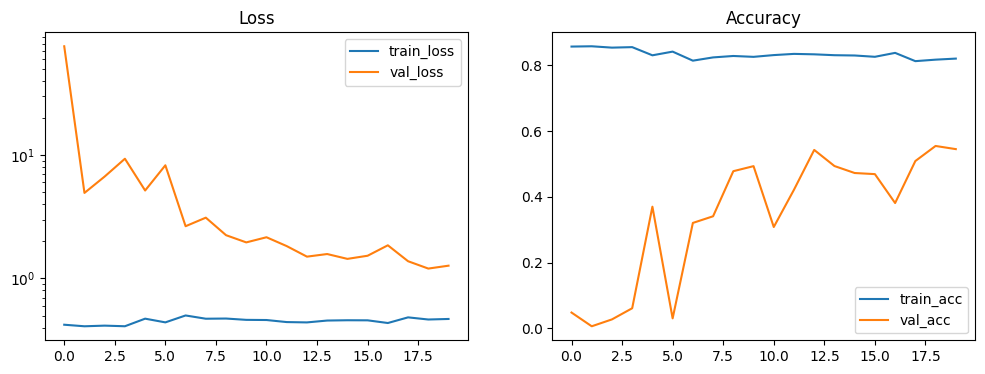

In [ ]:
import tensorflow as tf
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

# Callbacks
checkpoint_path = "/content/best_model.h5"
checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, mode="min", verbose=1)
early_cb = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_cb = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Create a training dataset (repeat=True) and a validation dataset (small, not repeated)
train_ds = make_tf_dataset(PARQUET_PATH, numeric_cols, label_col="label", batch_size=32768, repeat=True)
# Build a small validation set from a few batches:
val_gen = parquet_batch_generator(PARQUET_PATH, numeric_cols, label_col="label", batch_size=100000)
X_val, y_val = next(val_gen)   # first 100k rows used as validation
val_ds = tf.data.Dataset.from_tensor_slices((X_val.astype("float32"), y_val.astype("int32"))).batch(2048).prefetch(tf.data.AUTOTUNE)

# Hyperparameters
EPOCHS = 20
print("Steps per epoch:", steps_per_epoch)

# Rebuild the model to ensure a fresh graph context for the second fit call
model = build_mlp(num_features, num_classes)

# Fit model
history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, reduce_cb, early_cb],
    verbose=2
)

# After training, plot metrics
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.show()


In [ ]:
from tensorflow.keras import layers, models

def build_cnn_model(num_features, num_classes):
    inp = layers.Input(shape=(num_features, 1))

    x = layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [ ]:
def add_channel_dim(x, y):
    # x: (batch, num_features) → (batch, num_features, 1)
    x = tf.expand_dims(x, axis=-1)
    return x, y


In [ ]:
# Training dataset (repeat)
train_ds = make_tf_dataset(
    PARQUET_PATH,
    numeric_cols,
    label_col="label",
    batch_size=5000,
    repeat=True
)

# Add channel dimension for CNN
train_ds = train_ds.map(add_channel_dim)


In [ ]:
val_gen = parquet_batch_generator(
    PARQUET_PATH,
    numeric_cols,
    label_col="label",
    batch_size=10000
)

X_val, y_val = next(val_gen)
X_val = X_val.astype("float32").reshape(-1, num_features, 1)
y_val = y_val.astype("int32")

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(2048)


In [ ]:
model = build_cnn_model(num_features, num_classes)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 115, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 115, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 115, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 115, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 115, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 57, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 57, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 57, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 57, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 57, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,091 (441.76 KB)

 Trainable params: 112,323 (438.76 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    "/content/cnn_best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
EPOCHS = 10

history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_cb, reduce_cb],
    verbose=2
)


Sampling parquet... (this is memory-conscious)
Parquet has approx 7062606 rows.


/tmp/ipython-input-1467009186.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = big.groupby("label", group_keys=False).apply(


Sampled shape: (300000, 116)
Dropping columns: []
Numeric feature count: 115
Label mapping: {'benign': np.int64(0), 'gafgyt': np.int64(1), 'mirai': np.int64(2)}
Train shape: (216000, 115) Val shape: (24000, 115) Test shape: (60000, 115)
Class weights: {0: 0.7484563088629701, 1: 4.136742315426601, 2: 0.703145599968749}
Training LightGBM (this can take some minutes)...
[20]	train's multi_logloss: 0.179587	valid's multi_logloss: 0.179749
[40]	train's multi_logloss: 0.0452375	valid's multi_logloss: 0.0454306
[60]	train's multi_logloss: 0.0119616	valid's multi_logloss: 0.0121943
[80]	train's multi_logloss: 0.00325174	valid's multi_logloss: 0.00350861
[100]	train's multi_logloss: 0.000895207	valid's multi_logloss: 0.00115659
[120]	train's multi_logloss: 0.000257415	valid's multi_logloss: 0.000528555
[140]	train's multi_logloss: 8.40665e-05	valid's multi_logloss: 0.000387732
[160]	train's multi_logloss: 3.40866e-05	valid's multi_logloss: 0.000375386
[180]	train's multi_logloss: 1.78764e-05	va

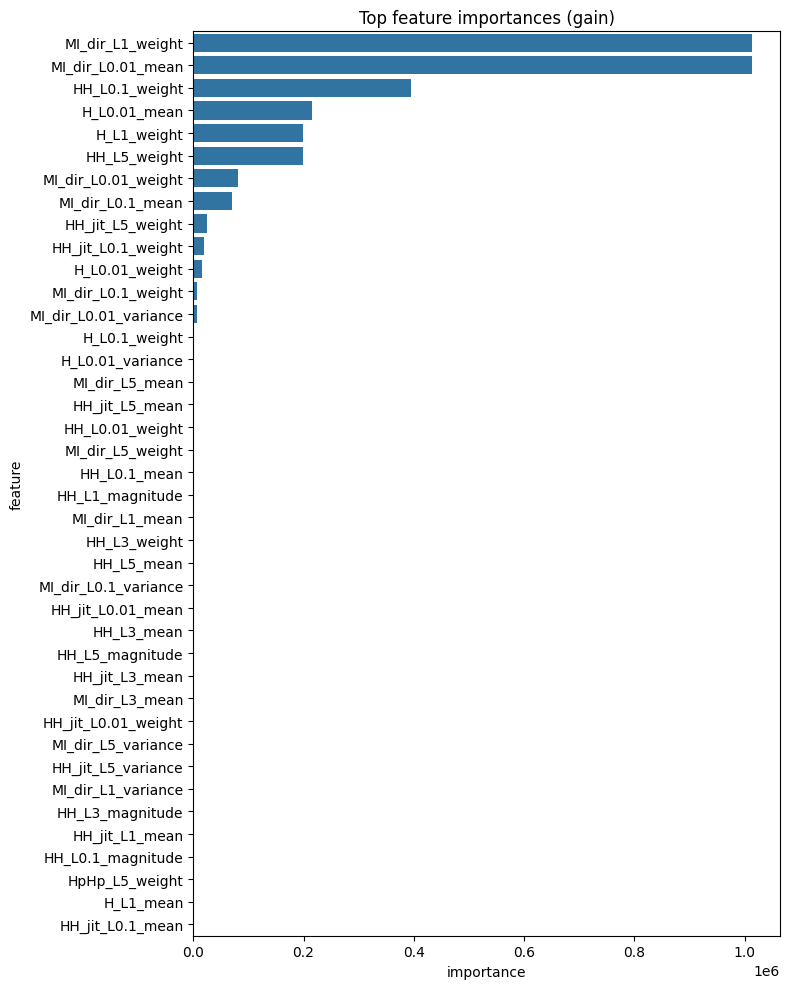

In [ ]:
# train_lgb_baiot.py
# Purpose: Train LightGBM on a sampled subset of the BAiOT parquet safely on CPU.
# Edit PARQUET_PATH and SAMPLE_ROWS as needed.

import os
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- CONFIG ----------
PARQUET_PATH = "baiot_merged.parquet"   # path to your merged parquet
SAMPLE_ROWS = 300_000                   # <= 500k recommended for slow laptop; tune down if needed
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1  # fraction of training for internal validation (used by LightGBM)
MODEL_PATH = "lgb_baiot_model.pkl"
SCALER_PATH = "scaler.pkl"
FEATURES_PATH = "selected_features.json"
# ----------------------------

# 1) Utility: sample rows from parquet efficiently by reading row-groups
def sample_parquet(path, n_rows, random_state=42):
    pf = pq.ParquetFile(path)
    total_rows = sum(pf.metadata.row_group(i).num_rows for i in range(pf.num_row_groups))
    print(f"Parquet has approx {total_rows} rows.")
    # If requested sample > total, read all
    if n_rows >= total_rows:
        print("Requested sample >= total rows — reading full dataset (may be heavy).")
        df = pf.read().to_pandas()
        return df
    # Strategy: read row-groups until we accumulate >= n_rows, then sample
    rows_accum = 0
    parts = []
    for rg in range(pf.num_row_groups):
        tb = pf.read_row_group(rg)
        df_rg = tb.to_pandas()
        parts.append(df_rg)
        rows_accum += len(df_rg)
        if rows_accum >= n_rows * 1.2:  # buffer a bit
            break
    big = pd.concat(parts, ignore_index=True)
    # stratified-ish sampling by label if possible
    if "label" in big.columns:
        # ensure we keep class proportions
        sampled = big.groupby("label", group_keys=False).apply(
            lambda x: x.sample(frac=min(1, n_rows * len(x) / max(len(big),1) / len(x)), random_state=random_state)
        ).reset_index(drop=True)
        # if we undershot or overshot, do random sample to exact n_rows
        if len(sampled) < n_rows:
            sampled = pd.concat([sampled, big.drop(sampled.index).sample(n_rows - len(sampled), random_state=random_state)], ignore_index=True)
        elif len(sampled) > n_rows:
            sampled = sampled.sample(n_rows, random_state=random_state).reset_index(drop=True)
        return sampled
    else:
        return big.sample(n_rows, random_state=random_state).reset_index(drop=True)

print("Sampling parquet... (this is memory-conscious)")
df = sample_parquet(PARQUET_PATH, SAMPLE_ROWS, random_state=RANDOM_STATE)
print("Sampled shape:", df.shape)

# 2) Quick cleanup & choose numeric features
# Drop obvious identifier/time columns if present (edit set below for your dataset)
drop_like = {"src_ip", "dst_ip", "timestamp", "time", "flow_start_time", "flow_end_time"}
got_cols = set(df.columns)
drop_cols = [c for c in drop_like if c in got_cols]
print("Dropping columns:", drop_cols)
df = df.drop(columns=drop_cols, errors="ignore")

# Ensure label exists
if "label" not in df.columns:
    raise SystemExit("No 'label' column found in sampled data. Edit script to use your label column name.")

# Auto-select numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove label if numeric (shouldn't be)
numeric_cols = [c for c in numeric_cols if c != "label"]
print("Numeric feature count:", len(numeric_cols))
if len(numeric_cols) == 0:
    raise SystemExit("No numeric features found. Check your dataset.")

# 3) Encode labels
le = LabelEncoder()
y = le.fit_transform(df["label"].astype(str))
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_map)

# 4) Optional: quick feature reduction using variance threshold or remove near-constant
# Remove constant columns
nunique = df[numeric_cols].nunique()
const_cols = nunique[nunique <= 1].index.tolist()
if const_cols:
    print("Removing constant columns:", const_cols)
    numeric_cols = [c for c in numeric_cols if c not in const_cols]

# 5) Prepare X,y and scale (scaling often helps GBDT a bit; optional)
X = df[numeric_cols].fillna(0).astype(float)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   # careful: on large sample; ok here
joblib.dump(scaler, SCALER_PATH)

# 6) Train-test split with stratify to keep class balance
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# 7) Create a small validation set from train for early stopping
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_train_val
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape, "Test shape:", X_test.shape)

# 8) Prepare LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# 9) Set class weights (balanced)
# compute weights per class inversely proportional to freq
(unique, counts) = np.unique(y_train, return_counts=True)
class_weights = {int(u): float(len(y_train) / (len(unique) * c)) for u, c in zip(unique, counts)}
print("Class weights:", class_weights)

# 10) LightGBM parameters tuned for CPU and stable accuracy
params = {
    "objective": "multiclass",
    "num_class": len(le.classes_),
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 64,             # smaller on CPU
    "learning_rate": 0.05,        # conservative
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 100,
    "verbose": -1,
    "num_threads": max(1, os.cpu_count() - 1)
}

# 11) Train with early stopping
print("Training LightGBM (this can take some minutes)...")
bst = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False), lgb.log_evaluation(period=20)], # Fix: use callbacks for early stopping and verbose_eval
    # fobj=None,  # Removed fobj
    # feval=None  # Removed feval
)

# 12) Predict & evaluate
y_pred_proba = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# 13) Save model & feature list
joblib.dump(bst, MODEL_PATH)
import json
with open(FEATURES_PATH, "w") as f:
    json.dump(numeric_cols, f)
print("Saved model ->", MODEL_PATH)
print("Saved feature list ->", FEATURES_PATH)

# 14) Feature importance plot
fi = pd.DataFrame({
    "feature": numeric_cols,
    "importance": bst.feature_importance(importance_type="gain")
}).sort_values("importance", ascending=False).head(40)

plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", data=fi)
plt.title("Top feature importances (gain)")
plt.tight_layout()
plt.show()

# End

In [ ]:
pip install lightgbm pandas numpy pyarrow scikit-learn joblib


In [ ]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
import json
import os
import dask.dataframe as dd # Import dask.dataframe to access `data`

# ---------------- CONFIG ----------------
PARQUET_PATH = "baiot_merged.parquet"
MODEL_PATH = "lgb_baiot_full_stream.pkl"
SCALER_PATH = "scaler_stream.pkl"
FEATURES_PATH = "features_stream.json"
CHUNK_SIZE = 300_000           # rows per chunk — adjust for your RAM
RANDOM_STATE = 42
# -----------------------------------------

print("Loading parquet metadata...")
pf = pq.ParquetFile(PARQUET_PATH)
num_row_groups = pf.num_row_groups
print("Row groups:", num_row_groups)

# ---------------- STEP 1: SCAN FIRST CHUNK TO GET FEATURE NAMES ----------------
print("\nScanning first row group to get features and label encoder...")
first_batch = pf.read_row_group(0).to_pandas()

# Identify numeric features
numeric_cols = first_batch.select_dtypes(include=[np.number]).columns.tolist()
if "label" in numeric_cols:
    numeric_cols.remove("label")

print("Numeric features:", len(numeric_cols))

# Label encode full dataset labels
le = LabelEncoder()
# Fit LabelEncoder on all unique labels from the entire Dask DataFrame
data = dd.read_parquet(PARQUET_PATH) # Re-load dask dataframe to ensure `data` is available
all_unique_labels_from_dask = data["label"].unique().compute()
le.fit(all_unique_labels_from_dask.astype(str))

# Fit scaler on only a sample of numeric features to avoid memory issues
scaler_sample = first_batch[numeric_cols].sample(min(100000, len(first_batch)), random_state=RANDOM_STATE)
scaler = StandardScaler().fit(scaler_sample)

joblib.dump(scaler, SCALER_PATH)
with open(FEATURES_PATH, "w") as f:
    json.dump(numeric_cols, f)

print("Scaler + feature list saved.\n")

# ---------------- STEP 2: TRAIN LIGHTGBM IN STREAMING MODE ----------------
print("Starting streaming LightGBM training...")

lgb_model = None     # will hold incremental model
rounds_per_chunk = 200   # how many boosting rounds per chunk

for rg in range(num_row_groups):
    print(f"\nProcessing row group {rg+1}/{num_row_groups}...")

    # Load chunk
    df = pf.read_row_group(rg).to_pandas()

    # Filter relevant features
    df = df[numeric_cols + ["label"]]

    # Scale numeric features
    X = scaler.transform(df[numeric_cols].astype(float))

    # Encode labels
    y = le.transform(df["label"].astype(str))

    # Prepare dataset
    train_ds = lgb.Dataset(X, label=y)

    # LightGBM params
    params = {
        "objective": "multiclass",
        "num_class": len(le.classes_), # Now `len(le.classes_)` will always be correct (3)
        "metric": "multi_logloss",
        "learning_rate": 0.05,
        "num_leaves": 64,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "min_data_in_leaf": 50,
        "verbosity": -1
    }

    # Incremental training
    lgb_model = lgb.train(
        params,
        train_ds,
        num_boost_round=rounds_per_chunk,
        init_model=lgb_model,    #  continue training here
        keep_training_booster=True
    )

    print(f"Finished training chunk {rg+1}/{num_row_groups}")

# ---------------- STEP 3: SAVE FINAL MODEL ----------------
joblib.dump(lgb_model, MODEL_PATH)
print("\nTraining completed on FULL dataset!")
print(f"Model saved to: {MODEL_PATH}")
print("Scaler saved to:", SCALER_PATH)
print("Features saved to:", FEATURES_PATH)


Loading parquet metadata...
Row groups: 91

Scanning first row group to get features and label encoder...
Numeric features: 115
Scaler + feature list saved.

Starting streaming LightGBM training...

Processing row group 1/91...
Finished training chunk 1/91

Processing row group 2/91...
Finished training chunk 2/91

Processing row group 3/91...
Finished training chunk 3/91

Processing row group 4/91...
Finished training chunk 4/91

Processing row group 5/91...
Finished training chunk 5/91

Processing row group 6/91...
Finished training chunk 6/91

Processing row group 7/91...
Finished training chunk 7/91

Processing row group 8/91...
Finished training chunk 8/91

Processing row group 9/91...
Finished training chunk 9/91

Processing row group 10/91...
Finished training chunk 10/91

Processing row group 11/91...
Finished training chunk 11/91

Processing row group 12/91...
Finished training chunk 12/91

Processing row group 13/91...
Finished training chunk 13/91

Processing row group 14/91

[+] Loading artifacts...
Loaded model, scaler, and feature list.
[+] Parquet contains 91 row groups.

[+] Starting streaming evaluation...
  Processing row group 1/91...
  Processing row group 2/91...
  Processing row group 3/91...
  Processing row group 4/91...
  Processing row group 5/91...
  Processing row group 6/91...
  Processing row group 7/91...
  Processing row group 8/91...
  Processing row group 9/91...
  Processing row group 10/91...
  Processing row group 11/91...
  Processing row group 12/91...
  Processing row group 13/91...
  Processing row group 14/91...
  Processing row group 15/91...
  Processing row group 16/91...
  Processing row group 17/91...
  Processing row group 18/91...
  Processing row group 19/91...
  Processing row group 20/91...
  Processing row group 21/91...
  Processing row group 22/91...
  Processing row group 23/91...
  Processing row group 24/91...
  Processing row group 25/91...
  Processing row group 26/91...
  Processing row group 27/91...
  Proc

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


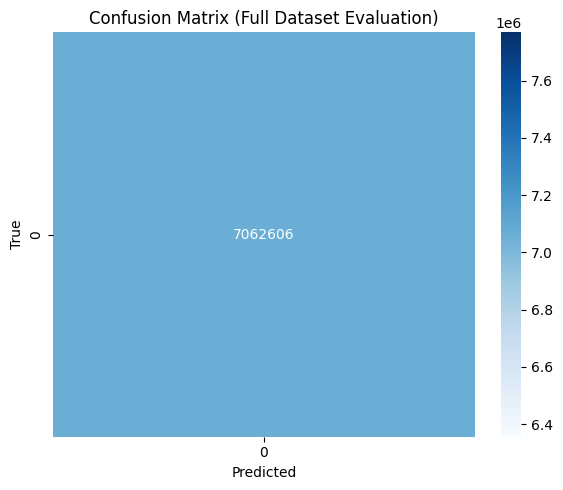

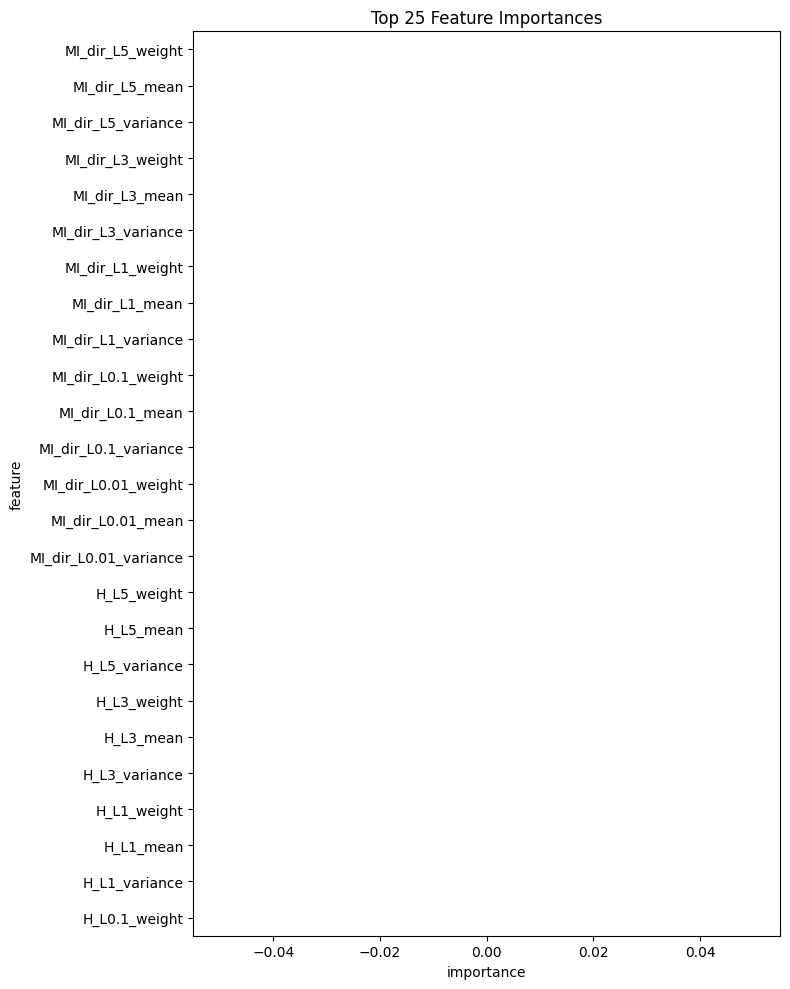

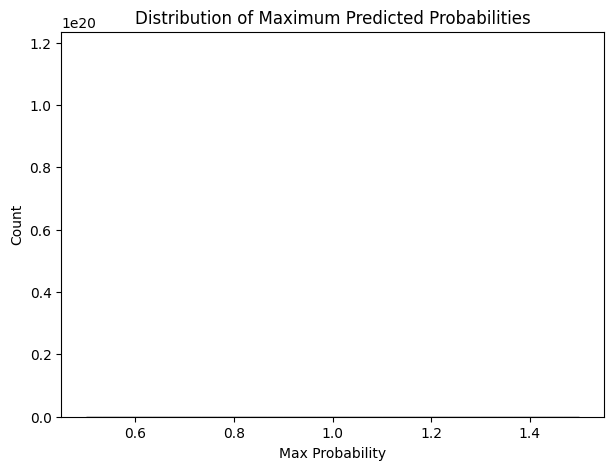


[+] Evaluation complete!


In [ ]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import joblib
import json
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- CONFIG ----------------
PARQUET_PATH = "baiot_merged.parquet"
MODEL_PATH = "lgb_baiot_full_stream.pkl"
SCALER_PATH = "scaler_stream.pkl"
FEATURES_PATH = "features_stream.json"
# -----------------------------------------

print("[+] Loading artifacts...")

model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

with open(FEATURES_PATH, "r") as f:
    feature_list = json.load(f)

print("Loaded model, scaler, and feature list.")

# Load parquet metadata
pf = pq.ParquetFile(PARQUET_PATH)
num_row_groups = pf.num_row_groups

print(f"[+] Parquet contains {num_row_groups} row groups.")

# Storage for evaluation
y_true_all = []
y_pred_all = []

print("\n[+] Starting streaming evaluation...")
for rg in range(num_row_groups):
    print(f"  Processing row group {rg+1}/{num_row_groups}...")

    # Load chunk
    df = pf.read_row_group(rg).to_pandas()
    df = df[feature_list + ["label"]]

    # Scale features
    X = scaler.transform(df[feature_list].astype(float))

    # Predict
    probs = model.predict(X)
    preds = np.argmax(probs, axis=1)

    # True labels
    y_true = df["label"].astype("category").cat.codes.values

    y_true_all.append(y_true)
    y_pred_all.append(preds)

print("\n[+] Completed evaluation streaming.")

# Convert lists → arrays
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

# ---------------- METRICS ----------------
print("\n================= Evaluation Report =================")
print("Accuracy:", accuracy_score(y_true_all, y_pred_all))
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all))

cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion Matrix:")
print(cm)

# ---------------- PLOTS ----------------

# 1️ Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Full Dataset Evaluation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 2️ Feature Importance
importances = model.feature_importance()
feat_imp = pd.DataFrame({"feature": feature_list, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(25)

plt.figure(figsize=(8,10))
sns.barplot(data=feat_imp, x="importance", y="feature")
plt.title("Top 25 Feature Importances")
plt.tight_layout()
plt.show()

# 3 Probability Distribution (optional)
# Only take a sample to avoid huge memory usage
sample_size = min(100000, len(y_pred_all))
sample_idx = np.random.choice(len(y_pred_all), sample_size, replace=False)

probs_sample = model.predict(
    scaler.transform(
        pf.read_row_group(0).to_pandas()[feature_list].astype(float)
    )
)

plt.figure(figsize=(7,5))
sns.histplot(
    probs_sample.max(axis=1),
    bins=30,
    kde=True,
    color="green"
)
plt.title("Distribution of Maximum Predicted Probabilities")
plt.xlabel("Max Probability")
plt.ylabel("Count")
plt.show()

print("\n[+] Evaluation complete!")


In [ ]:
# ensemble_lgb_xgb.py
import json, joblib, os
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

# ---------- CONFIG ----------
PARQUET_PATH = "baiot_merged.parquet"
LGB_MODEL_PATH = "lgb_baiot_full_stream.pkl"   # streaming model (full dataset)
SCALER_PATH = "scaler_stream.pkl"
FEATURES_PATH = "features_stream.json"
SAMPLE_ROWS = 300_000     # sample size for XGBoost training and stacking
RANDOM_STATE = 42
MODEL_OUT = "ensemble_stack.pkl"
# ----------------------------

print("Loading LightGBM streaming model + scaler + features...")
lgb_model = joblib.load(LGB_MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
with open(FEATURES_PATH, "r") as f:
    feature_list = json.load(f)

# ---------- helper: sample parquet (memory-conscious) ----------
def sample_parquet(path, n_rows, random_state=RANDOM_STATE):
    pf = pq.ParquetFile(path)
    total_rows = sum(pf.metadata.row_group(i).num_rows for i in range(pf.num_row_groups))
    print("Parquet total rows:", total_rows)
    # read row groups until buffer reached
    rows_accum = 0
    parts = []
    for rg in range(pf.num_row_groups):
        df_rg = pf.read_row_group(rg, columns=feature_list + ["label"]).to_pandas()
        parts.append(df_rg)
        rows_accum += len(df_rg)
        if rows_accum >= n_rows * 1.2:
            break
    big = pd.concat(parts, ignore_index=True)
    # stratified-ish sampling
    if "label" in big.columns:
        sampled = big.groupby("label", group_keys=False).apply(
            lambda x: x.sample(frac=min(1, n_rows * len(x) / max(len(big),1) / len(x)), random_state=random_state)
        ).reset_index(drop=True)
        if len(sampled) < n_rows:
            sampled = pd.concat([sampled, big.drop(sampled.index).sample(n_rows - len(sampled), random_state=random_state)], ignore_index=True)
        elif len(sampled) > n_rows:
            sampled = sampled.sample(n_rows, random_state=random_state).reset_index(drop=True)
        return sampled
    else:
        return big.sample(n_rows, random_state=random_state).reset_index(drop=True)

print("Sampling parquet for XGBoost training (size {})...".format(SAMPLE_ROWS))
df = sample_parquet(PARQUET_PATH, SAMPLE_ROWS)
print("Sampled shape:", df.shape)

# Prepare numeric X, y
X = df[feature_list].astype(float).fillna(0).values
y_labels = df["label"].astype(str).values

# label encode (consistent mapping saved)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y_labels)
print("Classes:", le.classes_)

# scale features using existing scaler if compatible, else fit a new one
try:
    X_scaled = scaler.transform(X)
except Exception:
    print("Scaler not compatible with sampled features. Fitting a new StandardScaler.")
    scaler_local = StandardScaler().fit(X)
    X_scaled = scaler_local.transform(X)
    joblib.dump(scaler_local, "scaler_sample.pkl")
    scaler = scaler_local

# train/val/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=RANDOM_STATE, stratify=y_trainval) # ~70/10/20

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ---------- Train XGBoost on sample ----------
print("Training XGBoost (on sample)...")
xgb_params = {
    "objective": "multi:softprob",
    "num_class": len(le.classes_),
    "eta": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "mlogloss",
    "tree_method": "hist",   # fast on CPU
    "nthread": max(1, os.cpu_count()-1)
}
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
evallist = [(dtrain,'train'), (dval,'eval')]
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=evallist, early_stopping_rounds=30, verbose_eval=50)

# ---------- Generate predictions for stacking ----------
def lgb_predict_proba_array(X_in):
    # LightGBM streaming model may be of type Booster and predict returns probabilities
    # Ensure we pass same scale
    return lgb_model.predict(X_in)  # shape (n, num_class)

print("Generating validation-level predictions for stacking...")
# XGB prob preds on validation
dval_all = xgb.DMatrix(X_val)
xgb_val_probs = xgb_model.predict(dval_all)  # (n_val, C)
# LGB val probs (use lgb_model.predict)
lgb_val_probs = lgb_predict_proba_array(X_val)  # shape (n_val, C)

# Build meta features: concatenate probabilities or use weighted avg
meta_val = np.hstack([xgb_val_probs, lgb_val_probs])  # shape (n, 2*C)

# Train meta learner (logistic regression)
meta = LogisticRegression(max_iter=1000, multi_class="multinomial")
meta.fit(meta_val, y_val)

# ---------- Evaluate ensemble on test set ----------
print("Preparing test predictions...")
dtest = xgb.DMatrix(X_test)
xgb_test_probs = xgb_model.predict(dtest)
lgb_test_probs = lgb_predict_proba_array(X_test)

meta_test = np.hstack([xgb_test_probs, lgb_test_probs])
meta_preds = meta.predict(meta_test)

print("Ensemble Test accuracy:", accuracy_score(y_test, meta_preds))
print("Classification report (ensemble):")
print(classification_report(y_test, meta_preds, target_names=le.classes_))
print("Confusion matrix:")
print(confusion_matrix(y_test, meta_preds))

# ---------- Save ensemble artifacts ----------
artifacts = {
    "xgb_model": "xgb_model.json",
    "lgb_model": LGB_MODEL_PATH,
    "meta_model": "meta_model.pkl",
    "label_encoder": "le.pkl",
    "features": FEATURES_PATH,
    "scaler": SCALER_PATH
}
# save xgb
xgb_model.save_model(artifacts["xgb_model"])
joblib.dump(meta, artifacts["meta_model"])
joblib.dump(le, "le.pkl")
print("Saved artifacts:", artifacts)

# Save wrapper ensemble info (weights, file names)
joblib.dump({
    "xgb_model_file": artifacts["xgb_model"],
    "lgb_model_file": artifacts["lgb_model"],
    "meta_model_file": artifacts["meta_model"],
    "le_file": "le.pkl",
    "features_file": FEATURES_PATH,
    "scaler_file": SCALER_PATH
}, MODEL_OUT)

print("Ensemble saved to:", MODEL_OUT)


Loading LightGBM streaming model + scaler + features...
Sampling parquet for XGBoost training (size 300000)...
Parquet total rows: 7062606


/tmp/ipython-input-3679558898.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = big.groupby("label", group_keys=False).apply(


Sampled shape: (300000, 116)
Classes: ['benign' 'gafgyt' 'mirai']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Train: (210000, 115) Val: (30000, 115) Test: (60000, 115)
Training XGBoost (on sample)...
[0]	train-mlogloss:0.95055	eval-mlogloss:0.95055
[50]	train-mlogloss:0.06141	eval-mlogloss:0.06161
[100]	train-mlogloss:0.00502	eval-mlogloss:0.00530
[150]	train-mlogloss:0.00045	eval-mlogloss:0.00073
[200]	train-mlogloss:0.00006	eval-mlogloss:0.00035
[250]	train-mlogloss:0.00002	eval-mlogloss:0.00030
[300]	train-mlogloss:0.00001	eval-mlogloss:0.00029
[334]	train-mlogloss:0.00001	eval-mlogloss:0.00029
Generating validation-level predictions for stacking...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Preparing test predictions...
Ensemble Test accuracy: 0.9999666666666667
Classification report (ensemble):
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     26722
      gafgyt       1.00      1.00      1.00      4834
       mirai       1.00      1.00      1.00     28444

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

Confusion matrix:
[[26722     0     0]
 [    1  4833     0]
 [    1     0 28443]]
Saved artifacts: {'xgb_model': 'xgb_model.json', 'lgb_model': 'lgb_baiot_full_stream.pkl', 'meta_model': 'meta_model.pkl', 'label_encoder': 'le.pkl', 'features': 'features_stream.json', 'scaler': 'scaler_stream.pkl'}
Ensemble saved to: ensemble_stack.pkl


In [ ]:
!pip install h2o

In [ ]:
# h2o_automl_baiot.py
import json, joblib
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

PARQUET_PATH = "baiot_merged.parquet"
SAMPLE_ROWS = 300_000 # Increased sample size to ensure multiple classes
RANDOM_STATE = 42
MAX_RUN_SECONDS = 3600   # 1 hour for AutoML; reduce for faster runs
MODEL_OUT_DIR = "h2o_automl_model"

# sample function (re-use previous sample logic)
def sample_parquet(path, n_rows, random_state=RANDOM_STATE):
    pf = pq.ParquetFile(path)
    rows_accum = 0
    parts = []
    for rg in range(pf.num_row_groups):
        df_rg = pf.read_row_group(rg).to_pandas()
        parts.append(df_rg)
        rows_accum += len(df_rg)
        if rows_accum >= n_rows * 1.2:
            break
    big = pd.concat(parts, ignore_index=True)
    if "label" in big.columns:
        sampled = big.groupby("label", group_keys=False).apply(
            lambda x: x.sample(frac=min(1, n_rows * len(x) / max(len(big),1) / len(x)), random_state=random_state)
        ).reset_index(drop=True)
        if len(sampled) < n_rows:
            sampled = pd.concat([sampled, big.drop(sampled.index).sample(n_rows - len(sampled), random_state=random_state)], ignore_index=True)
        elif len(sampled) > n_rows:
            sampled = sampled.sample(n_rows, random_state=random_state).reset_index(drop=True)
        return sampled
    else:
        return big.sample(n_rows, random_state=random_state).reset_index(drop=True)

print("Sampling for H2O AutoML...")
df = sample_parquet(PARQUET_PATH, SAMPLE_ROWS)
print("Sample shape:", df.shape)

# Prepare data: H2O needs a frame and a target column as factor for classification
target = "label"
# convert label to string
df[target] = df[target].astype(str)

# split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, stratify=df[target])

# Start H2O
h2o.init(max_mem_size="6G")   # limit memory; reduce if needed
print("H2O initialized.")

# convert to H2O frames
hf_train = h2o.H2OFrame(train_df)
hf_test = h2o.H2OFrame(test_df)

# ensure target is factor
hf_train[target] = hf_train[target].asfactor()
hf_test[target] = hf_test[target].asfactor()

# Run AutoML
aml = H2OAutoML(max_runtime_secs=MAX_RUN_SECONDS, seed=RANDOM_STATE, nfolds=5, verbosity="info")
aml.train(x=[c for c in hf_train.columns if c != target], y=target, training_frame=hf_train)

# Leader model
lb = aml.leaderboard
print(lb.head(rows=10))
leader = aml.leader
print("Leader model:", type(leader), leader.model_id)

# Evaluate on test
perf = leader.model_performance(hf_test)
print(perf)

# Save leader model
h2o.save_model(model=leader, path=MODEL_OUT_DIR, force=True)
print("Saved H2O leader model to:", MODEL_OUT_DIR)

# Optional: convert leader to MOJO for fast scoring (Java) or H2O POJO
mojo_path = h2o.save_model(leader, path=MODEL_OUT_DIR, export_cross_validation_predictions=False)
print("Saved model (H2O path):", mojo_path)

# Shutdown H2O when done
h2o.cluster().shutdown(prompt=False)


Sampling for H2O AutoML...


/tmp/ipython-input-3219647339.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = big.groupby("label", group_keys=False).apply(


Sample shape: (300000, 116)
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,29 mins 34 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_6esotb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.428 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


H2O initialized.
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:03:20.736: Project: AutoML_3_20251205_190320
19:03:20.746: Setting stopping tolerance adaptively based on the training frame: 0.002041241452319315
19:03:20.746: Build control seed: 42
19:03:20.747: training frame: Frame key: AutoML_3_20251205_190320_training_py_2_sid_baf3    cols: 116    rows: 240000  chunks: 74    size: 215055546  checksum: 2378478405251285820
19:03:20.747: validation frame: NULL
19:03:20.747: leaderboard frame: NULL
19:03:20.747: blending frame: NULL
19:03:20.747: response column: label
19:03:20.747: fold column: null
19:03:20.747: weights column: null
19:03:20.749: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w

H2OResponseError: Server error water.exceptions.H2OIllegalArgumentException:
  Error: Illegal argument: dir of function: exportModel: water.api.FSIOException: FS IO Failure: 
 accessed path : file:/content/h2o_automl_model/DRF_1_AutoML_3_20251205_190320 msg: File already exists
  Request: GET /99/Models.bin/DRF_1_AutoML_3_20251205_190320
    params: {'dir': 'h2o_automl_model/DRF_1_AutoML_3_20251205_190320', 'force': 'False', 'export_cross_validation_predictions': 'False'}
